In [62]:
import rasterio
import geopandas as gpd
import pyproj
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from numpy import *
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
from sklearn.metrics import r2_score

In [63]:
def SD_Regression(path, RADAR, RADAR_pred, SI_Mask, SI_Mask_pred, outdir):
    
    i = 0
    for file in os.listdir(path):
        if file.endswith('shp'):

#            filename = file[3:7]
            points = os.path.join(path,file)
            pts = gpd.read_file(points)
            
            if i != 0:
                df_train = pd.concat([df_train,pts])
            else: 
                df_train = pts
                i=i+1           
    
    print('Beams Merged')
    
    df_train['lon'] = df_train.geometry.x
    df_train['lat'] = df_train.geometry.y

    coords = [(x,y) for x, y in zip(df_train.lon, df_train.lat)]

    src = rasterio.open(RADAR)
    src_mask = rasterio.open(SI_Mask)
    # Sample the raster at every point location and store values in DataFrame
    df_train['RADAR'] = [x[0] for x in src.sample(coords)]
    
    df_train['SI_Mask'] = [x[0] for x in src_mask.sample(coords)]
    
    print('Training data ready')
    
    df_train = df_train[df_train['SI_Mask'] > 0]
    df_train = df_train[df_train['ESD'] > 0.5]
    #df_train = df_train[df_train['RADAR'] > 0]
    
    print('Shape of training data ', df_train.shape)
    
    plt.plot(df_train.AT_dist, df_train.ESD, 'o', color='black');
    plt.plot(df_train.AT_dist, df_train.RADAR, 'o', color='black');
    plt.plot(df_train.RADAR, df_train.ESD, 'o', color='black');
    
    X = np.array(df_train.RADAR).reshape(-1,1)
    y = np.array(df_train.ESD)
    #reg = LinearRegression().fit(X, y)
    #reg = RandomForestRegressor(max_depth=2, random_state=0).fit(X,y)
    reg = lgbm.LGBMRegressor()
    reg.fit(X, y)
    
    print('Modelled')
    
    with rasterio.open(SI_Mask_pred, 'r') as mask:
        mask_data = mask.read()
        mask_data = np.array(mask_data).reshape(-1,1)
        mask_data = mask_data.flatten()
    
    with rasterio.open(RADAR_pred, 'r') as dataset:
        
        data = dataset.read()
        og_shape = data.shape
        
        data = np.array(data).reshape(-1,1)
        
        where_are_NaNs = isnan(data)
        data[where_are_NaNs] = 0
        
        y_pred = reg.predict(data)
        
        print('Predicted')
        
        #y_pred = y_pred.flatten()
        y_pred = y_pred * mask_data
        profile = dataset.profile
        y_pred = y_pred.reshape(og_shape)
        
        print('Masked')

        y_pred_train = reg.predict(X)
        r2 = str(r2_score(y, y_pred_train).round(2))
        print('R2 score is: ', r2)
        
        with rasterio.open('C:/Users/Rasmu/Documents/Thesis/Regression/VHDIFF_LGBM_'+r2+'.tif', 'w', **profile) as dst:
            dst.write(y_pred.astype(rasterio.float32))

        
    return df_train

In [64]:
path = 'C:/Users/Rasmu/Documents/Thesis/SD_Rescaled/'
RADAR = 'C://Users/Rasmu/Documents/Thesis/S1_resampled/VH_diff3_100m_S2.tif'
RADAR_pred = 'C://Users/Rasmu/Documents/Thesis/S1_resampled/VH_diff4_100m_S2.tif'
SI_Mask = 'C:/Users/Rasmu/Documents/Thesis/S2_Masks/SI.tif'
SI_Mask_pred = 'C:/Users/Rasmu/Documents/Thesis/S2_Masks/SI.tif'
outdir = 'C:/Users/Rasmu/Documents/Thesis/Regression/'

Beams Merged
Training data ready
Shape of training data  (6969, 8)
Modelled
Predicted
Masked
R2 score is:  0.49


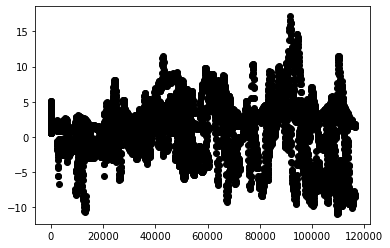

In [65]:
df = SD_Regression(path, RADAR, RADAR_pred, SI_Mask, SI_Mask_pred, outdir)

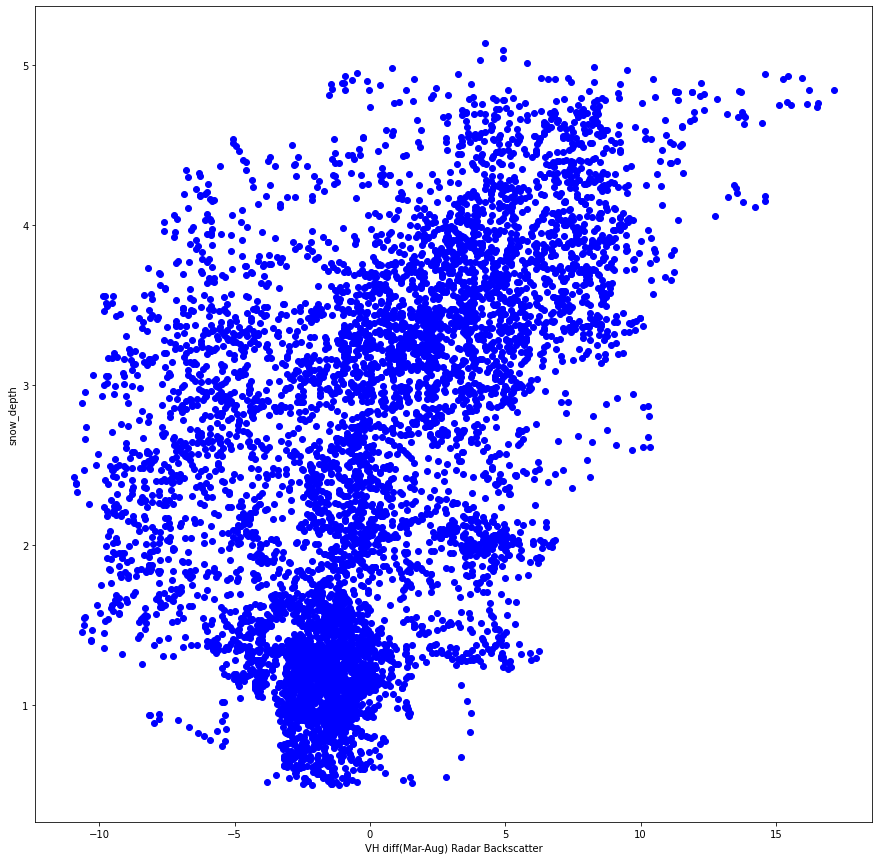

In [66]:
plt.figure(figsize=(15, 15))
plt.xlabel('VH diff(Mar-Aug) Radar Backscatter')
plt.ylabel('snow_depth')
plt.scatter(df.RADAR, df.ESD, color='blue');